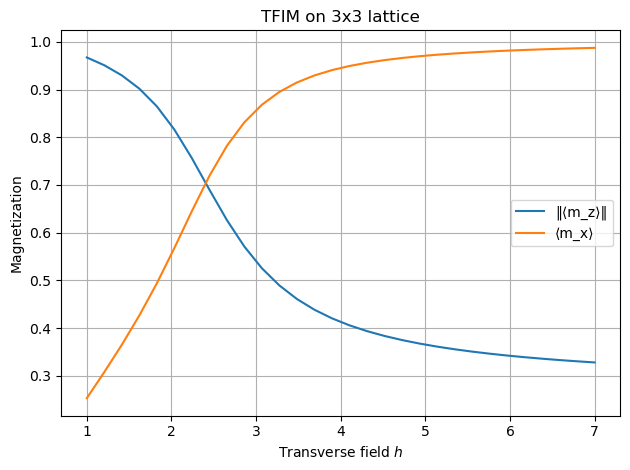

In [1]:
# Imports and fixed config
from pathlib import Path
import jax
import jax.numpy as jnp
import numpy as np
from scipy.sparse.linalg import eigsh

from netket.graph import Hypercube
from netket.hilbert import Spin
from netket.operator import Ising, LocalOperator


def calculate_groundstate(hamiltonian: LocalOperator):
    eigvals, eigvecs = eigsh(hamiltonian.to_sparse(), k=1, which='SA')
    return eigvals[0], jnp.array(eigvecs[:, 0], dtype=jnp.complex64)

def magnetization_z_spontaneous(state: jnp.ndarray) -> jnp.ndarray:
    state_size = state.shape[0]
    num_qubits = int(jnp.log2(state.shape[0]))
    assert 2**num_qubits ==state_size, "State vector length must be a power of 2."

    probs = jnp.abs(state)**2 # born rule gives frequencies

    basis_indices = jnp.arange(state_size)                          # (2**n,)
    bitstrings = ((basis_indices[:, None] >> jnp.arange(num_qubits)[::-1]) & 1)  # (2**n, n)
    spins = 1.0 - 2.0 * bitstrings

    magnetization_vector = jnp.abs(spins.mean(axis=1))      # taking the absolute value to get the spontaneous magnetization

    magnetization = jnp.sum(probs * magnetization_vector)
    return magnetization

def overlap_after_spin_flip(state: jnp.ndarray, num_qubits: int, flip_idx: int):
    indices = jnp.arange(2**num_qubits)
    flipped = indices ^ (1 << (num_qubits - 1 - flip_idx))
    return jnp.vdot(state, state[flipped]).real


def magnetization_x_from_state(state: jnp.ndarray):
    num_qubits = int(jnp.log2(state.shape[0]))
    overlaps = jnp.array([overlap_after_spin_flip(state, num_qubits, i)
                          for i in range(num_qubits)])
    return overlaps.mean()


# set up 3×3 TFIM
side_length = 3
graph = Hypercube(length=side_length, n_dim=2, pbc=True)
hilbert = Spin(s=0.5, N=graph.n_nodes)

def sweep_magnetization(h_min= 1.0, h_max=7.0, num_points=30):
    h_vals = jnp.linspace(h_min, h_max, num_points)
    mz_vals, mx_vals = [], []
    key = jax.random.PRNGKey(42)
    for h in h_vals:
        ham = Ising(hilbert, graph, h=float(h), J=-1.0) # J=-1.0 for TFIM
        _, state = calculate_groundstate(ham)
        key, subkey = jax.random.split(key)
        mz = magnetization_z_spontaneous(state)
        mx = magnetization_x_from_state(state)
        mz_vals.append(mz)
        mx_vals.append(mx)
    return h_vals, jnp.array(mz_vals), jnp.array(mx_vals)


import matplotlib.pyplot as plt

h_vals, mz_vals, mx_vals = sweep_magnetization()

plt.plot(h_vals, mz_vals, label='‖⟨m_z⟩‖')
plt.plot(h_vals, mx_vals, label='⟨m_x⟩')
plt.xlabel("Transverse field $h$")
plt.ylabel("Magnetization")
plt.title(f"TFIM on {side_length}x{side_length} lattice")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
#h_vals = [1.0, 2.0, 2.8, 3.0, 3.3, 3.6, 4.0, 5.0, 6.0, 7.0]

In [18]:
magnetizations_z_rbm = [
    0.96355546, 0.808689, 0.5733111, 0.522311, 0.4692221,
    0.43335545, 0.402711, 0.35899994, 0.33684438, 0.32379994
]
errors_z = [
    0.00095043, 0.00238831, 0.00302786, 0.00298788, 0.00285686,
    0.00275991, 0.00264666, 0.00244836, 0.00232545, 0.00225067
]

magnetizations_x_rbm = [
    0.6690979, 0.838016, 0.95723516, 0.974556, 0.99090964,
    0.9998612, 1.0074241, 1.0173744, 1.0212257, 1.0226396
]
errors_x = [
    0.00393375, 0.0032602, 0.00212176, 0.00185027, 0.00154136,
    0.0013611, 0.00117306, 0.00087963, 0.00075712, 0.00072234
]

h_vals_rbm = [1.0, 2.0, 2.8, 3.0, 3.3, 3.6, 4.0, 5.0, 6.0, 7.0]

ValueError: 'tab:magenta' is not a valid value for color

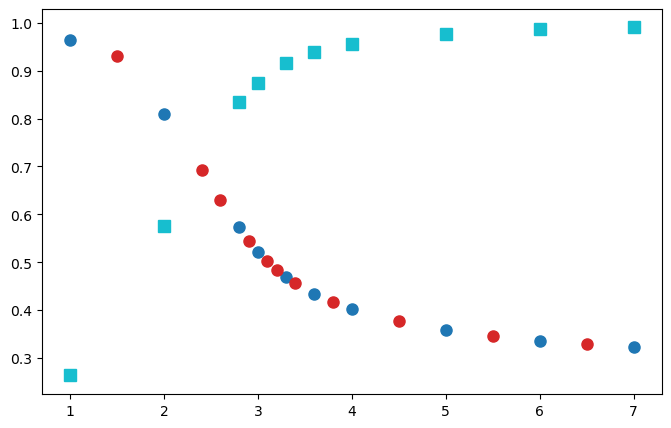

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Data loading cell ---
df = pd.read_csv('./magnetization.csv')
# Convert columns to numeric
for col in ['h', 'mag_z', 'mag_z_error', 'mag_x', 'mag_x_error']:
    df[col] = pd.to_numeric(df[col])

# --- Plotting cell: support vs generated ---
df_support = df[df['type'] == 'support']
df_generated = df[df['type'] == 'generated']

fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
ax.set_facecolor('white')
plt.rcParams.update({"font.family": "serif"})

# Plot support points
ax.errorbar(
    df_support['h'], df_support['mag_z'], yerr=df_support['mag_z_error'],
    fmt='o', markersize=8, label=r'Support $⟨\sigma^z⟩$', color='tab:blue', zorder=2
)
ax.errorbar(
    df_support['h'], df_support['mag_x'], yerr=df_support['mag_x_error'],
    fmt='s', markersize=8, label=r'Support $⟨\sigma^x⟩$', color='tab:cyan', zorder=2
)

# Plot generated points
ax.errorbar(
    df_generated['h'], df_generated['mag_z'], yerr=df_generated['mag_z_error'],
    fmt='o', markersize=8, label=r'Generated $⟨\sigma^z⟩$', color='tab:red', zorder=2
)
ax.errorbar(
    df_generated['h'], df_generated['mag_x'], yerr=df_generated['mag_x_error'],
    fmt='s', markersize=8, label=r'Generated $⟨\sigma^x⟩$', color='tab:magenta', zorder=2
)

# Labels and styling
ax.set_xlabel(r'$h$', fontsize=14)
ax.set_ylabel('Magnetization', fontsize=14)
ax.set_title('2d-TFIM RBM Magnetizations', fontsize=16)

ax.legend(frameon=True, framealpha=1, loc='best', fontsize=12)

# Remove top & right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

NameError: name 'h_vals_rbm' is not defined

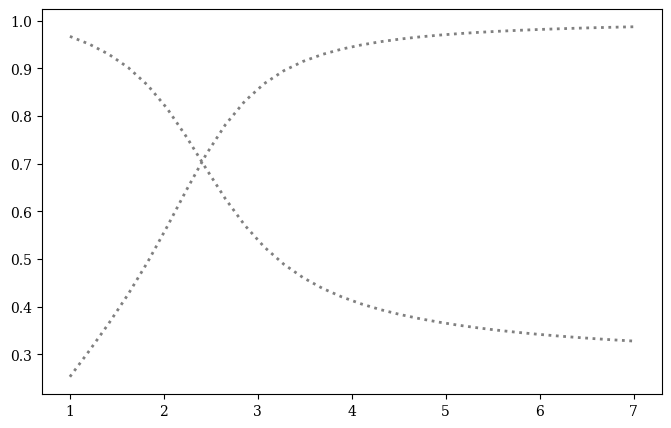

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
ax.set_facecolor('white')
plt.rcParams.update({"font.family": "serif"})

# Plot the two reference curves in medium gray, slightly thicker, hidden in legend
ax.plot(h_vals, mz_vals,
        ':', color='gray', linewidth=2.0,
        label='_nolegend_', zorder=1)
ax.plot(h_vals, mx_vals,
        ':', color='gray', linewidth=2.0,
        label='_nolegend_', zorder=1)

# Plot RBM markers on top
ax.plot(h_vals_rbm, magnetizations_z_rbm,
        'o', color='red', markersize=8,
        label=r'$\langle \sigma^z \rangle_{\mathrm{RBM}}$',
        zorder=2)
ax.plot(h_vals_rbm, magnetizations_x_rbm,
        'D', color='blue', markersize=8,
        label=r'$\langle \sigma^x \rangle_{\mathrm{RBM}}$',
        zorder=2)

# Single proxy line for legend
ax.plot([], [], ':', color='gray', linewidth=2.0,
        label=r'$\langle \sigma^{z/x}\rangle_{\mathrm{state~vector}}$')

# Labels and title
ax.set_xlabel(r'$h$', fontsize=14)
ax.set_ylabel('Magnetization', fontsize=14)
ax.set_title('2d-TFIM', fontsize=16)

# X-ticks every 0.5
h_min, h_max = min(h_vals), max(h_vals)
xticks = np.arange(np.floor(h_min * 2) / 2,
                   np.ceil(h_max * 2) / 2 + 0.01,
                   0.5)
ax.set_xticks(xticks)
ax.set_xticklabels([f"${x:.1f}$" for x in xticks])

# Legend with even bigger font
ax.legend(frameon=True, framealpha=1, loc='best', fontsize=20)

# Remove top & right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('tfim_magnetization_highres.png', dpi=300)
plt.show()


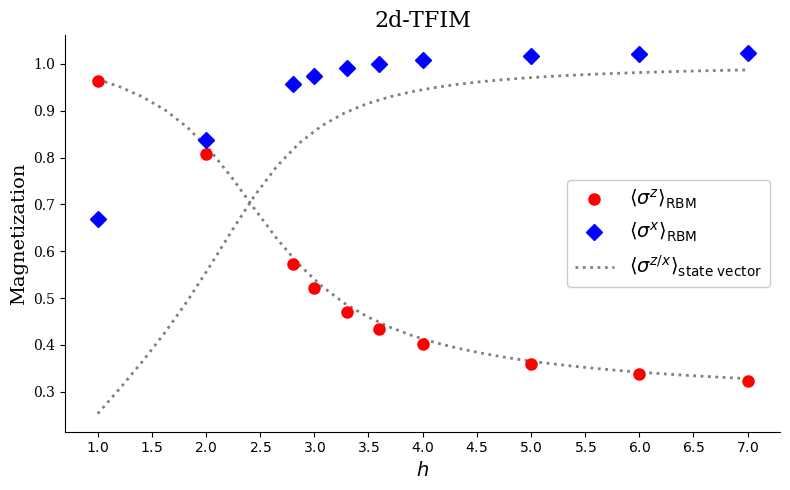

In [19]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
ax.set_facecolor('white')
plt.rcParams.update({"font.family": "serif"})

# Plot the two reference curves in medium gray, slightly thicker, hidden in legend
ax.plot(h_vals, mz_vals,
        ':', color='gray', linewidth=2.0,
        label='_nolegend_', zorder=1)
ax.plot(h_vals, mx_vals,
        ':', color='gray', linewidth=2.0,
        label='_nolegend_', zorder=1)

# Plot RBM markers on top
ax.plot(h_vals_rbm, magnetizations_z_rbm,
        'o', color='red', markersize=8,
        label=r'$\langle \sigma^z \rangle_{\mathrm{RBM}}$',
        zorder=2)
ax.plot(h_vals_rbm, magnetizations_x_rbm,
        'D', color='blue', markersize=8,
        label=r'$\langle \sigma^x \rangle_{\mathrm{RBM}}$',
        zorder=2)

# Single proxy line for legend
ax.plot([], [], ':', color='gray', linewidth=2.0,
        label=r'$\langle \sigma^{z/x}\rangle_{\mathrm{state~vector}}$')

# Labels and title
ax.set_xlabel(r'$h$', fontsize=14)
ax.set_ylabel('Magnetization', fontsize=14)
ax.set_title('2d-TFIM', fontsize=16)

# X-ticks every 0.5
h_min, h_max = min(h_vals), max(h_vals)
xticks = np.arange(np.floor(h_min * 2) / 2,
                   np.ceil(h_max * 2) / 2 + 0.01,
                   0.5)
ax.set_xticks(xticks)
ax.set_xticklabels([f"${x:.1f}$" for x in xticks])

# Legend with bigger font
ax.legend(frameon=True, framealpha=1, loc='best', fontsize=14)

# Remove top & right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('tfim_magnetization_highres.png', dpi=300)
plt.show()